<img src="https://raw.githubusercontent.com/MLMI2-CSSI/foundry/main/assets/foundry-black.png" width=450>

# Foundry Dendrite Segmentation Tutorial for Beginners

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/MLMI2-CSSI/foundry/blob/main/examples/dendrite-segmentation/dendrite_segmentation.ipynb)

This introduction uses Foundry to:


1.   Load data from Foundry
2.   Build a predictuve U-Net model
3. Create augmented data to use with the model

This notebook is set up to run as a [Google Colaboratory](https://colab.research.google.com/notebooks/intro.ipynb#scrollTo=5fCEDCU_qrC0) notebook, which allows you to run python code in the browser, or as a [Jupyter](https://jupyter.org/) notebook, which runs locally on your machine.

The code in the next cell will detect your environment to make sure that only cells that match your environment will run.

In [1]:
try:
    # Check to see if we are in the Google Colab environment
    import google.colab
    no_local_server = True
    no_browser = True
except: # when not in Google Colab
    no_local_server = False
    no_browser = False

globus = False # by default, we download the data with https, which can be inefficient, but works in most locations

# # To download with Globus, install a local Globus Connect Personal (GCP) endpoint, and uncomment this block
# # GCP install instructions https://www.globus.org/globus-connect-personal
# globus = True

# Installing Foundry and Other Modules
First we'll need to install Foundry as well as a few other packages. If you're using Google Colab, this code block will install these packages into the Colab environment.

If you are running locally, it will install these modules onto your machine if you do not already have them. We also have a [requirements file](https://github.com/MLMI2-CSSI/foundry/tree/main/examples/dendrite-segmentation) included with this notebook. You can run `pip install -r requirements.txt` in your terminal to set up your environment locally.

In [ ]:
!pip install scikit-learn
!pip install foundry_ml
!pip install scikit-image
!pip install tensorflow
!pip install keras-unet
!pip install opencv-python

# Importing Packages
Now we can import Foundry, which will allow us to load the data.

We'll be using [scikit-image](https://scikit-image.org/) for image processing; [Keras](https://keras.io/) and [TensorFlow](https://www.tensorflow.org/) to create our model; and [pandas](https://pandas.pydata.org/), [OpenCV](https://pypi.org/project/opencv-python/), and [NumPy ](https://numpy.org/)to work with our data.

In [ ]:
from foundry import Foundry
from skimage.io import imshow, imread
from keras_unet.models import custom_unet
import matplotlib.pyplot as plt
from keras_unet.utils import plot_imgs
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from keras_unet.metrics import iou, iou_thresholded
from keras_unet.losses import jaccard_distance
from keras_unet.utils import get_augmented

# Instantiating Foundry
To instantiate Foundry, you'll need a [Globus](https://www.globus.org) account. Once you have your account, you can instantiate Foundry using the code below. When you instantiate Foundry locally, be sure to have your Globus endpoint turned on (you can do that with [Globus Connect Personal](https://www.globus.org/globus-connect-personal)). When you instantiate Foundry on Google Colab, you'll be given a link in the cell's output and asked to enter the provided auth code.


In [ ]:
f = Foundry(index="mdf", no_local_server=no_local_server, no_browser=no_browser)

# Loading the Data
Now we can use our instance of Foundry to load the data using `f.load()`. Once the data is loaded and accessible, we load the data into the client using `f.load_data()`.

In [5]:
f.load("foundry_stan_segmentation_v1.1", globus=globus)

Foundry(dc={'identifier': {'identifier': '10.18126/d4kn-cz3p', 'identifierType': 'DOI'}, 'rightsList': [{'rights': 'CC-BY 4.0'}], 'creators': [{'creatorName': 'Stan, Tiberiu', 'affiliations': ['Northwestern University'], 'familyName': 'Stan', 'givenName': 'Tiberiu'}, {'creatorName': 'Thompson, Zach', 'affiliations': ['Northwestern University'], 'familyName': 'Thompson', 'givenName': 'Zach'}, {'creatorName': 'Voorhees, Peter', 'affiliations': ['Northwestern University'], 'familyName': 'Voorhees', 'givenName': 'Peter'}], 'subjects': [{'subject': 'machine learning'}, {'subject': 'foundry'}, {'subject': 'segmentation'}, {'subject': 'metals and alloys'}], 'publicationYear': 2021, 'publisher': 'Materials Data Facility', 'dates': [{'date': '2021-07-26', 'dateType': 'Accepted'}], 'titles': [{'title': 'Dataset for Semantic Segmentation of Dendrites via Machine Learning'}], 'resourceType': {'resourceTypeGeneral': 'Dataset', 'resourceType': 'Dataset'}}, mdf={'resource_type': 'dataset', 'organizations': ['Foundry'], 'ingest_date': '2021-07-26T18:25:34.286195Z', 'source_id': 'foundry_stan_segmentation_v1.1', 'scroll_id': 0, 'version': 1, 'source_name': 'foundry_stan_segmentation'}, dataset=FoundryDataset(keys=[FoundryKey(key=['train/input'], type='input', classes=None, description='input, unlabeled images', filter=None, units=''), FoundryKey(key=['train/output'], type='target', classes=None, description='target, labeled images', filter=None, units='')], splits=[FoundrySplit(type='train', path='foundry.hdf5', label='train')], data_type=<FoundryDatasetType.hdf5: 'hdf5'>, short_name='segmentation', dataframe=None, task_type=['unsupervised', 'segmentation'], domain=['materials science', 'chemistry'], n_items=30), config=FoundryConfig(dataframe_file='foundry_dataframe.json', data_file='foundry.hdf5', metadata_file='foundry_metadata.json', destination_endpoint=None, local=False, metadata_key='foundry', organization='foundry', local_cache_dir='./data'), dlhub_client=<dlhub_sdk.client.DLHubClient object at 0x79387f54ae60>, forge_client=<mdf_forge.forge.Forge object at 0x793914d51e40>, connect_client=<mdf_connect_client.mdfcc.MDFConnectClient object at 0x793914d50b50>, transfer_client=<globus_sdk.services.transfer.client.TransferClient object at 0x79387f54aa10>, auth_client=<globus_sdk.services.auth.client.service_client.AuthClient object at 0x793914d51180>, auths={'openid': <globus_sdk.authorizers.refresh_token.RefreshTokenAuthorizer object at 0x793915c3f850>, 'data_mdf': <globus_sdk.authorizers.refresh_token.RefreshTokenAuthorizer object at 0x79387f54b6a0>, 'petrel': <globus_sdk.authorizers.refresh_token.RefreshTokenAuthorizer object at 0x79387f54b400>, 'dlhub': <globus_sdk.authorizers.refresh_token.RefreshTokenAuthorizer object at 0x79387f54b340>, 'https://auth.globus.org/scopes/82f1b5c6-6e9b-11e5-ba47-22000b92c6ec/https': <globus_sdk.authorizers.refresh_token.RefreshTokenAuthorizer object at 0x79387f54b2e0>, 'search': <globus_sdk.services.search.client.SearchClient object at 0x79388a8d7eb0>, 'mdf_connect': <globus_sdk.authorizers.refresh_token.RefreshTokenAuthorizer object at 0x79387f54b310>, 'transfer': <globus_sdk.services.transfer.client.TransferClient object at 0x79387f54aa10>, 'https://auth.globus.org/scopes/d31d4f5d-be37-4adc-a761-2f716b7af105/action_all': <globus_sdk.authorizers.refresh_token.RefreshTokenAuthorizer object at 0x79387f54add0>, 'https://auth.globus.org/scopes/f10a69a9-338c-4e5b-baa1-0dc92359ab47/https': <globus_sdk.authorizers.refresh_token.RefreshTokenAuthorizer object at 0x79387f54afe0>, 'https://auth.globus.org/scopes/facd7ccc-c5f4-42aa-916b-a0e270e2c2a9/all': <globus_sdk.authorizers.refresh_token.RefreshTokenAuthorizer object at 0x79387f54a860>, 'search_authorizer': <globus_sdk.authorizers.refresh_token.RefreshTokenAuthorizer object at 0x793914d50eb0>}, index='mdf')

In [6]:
res = f.load_data()
X = res['train']['input']['train/input']
y = res['train']['target']['train/output']

# Visualizing the Data

Now that we've loaded the data, let's take a look!

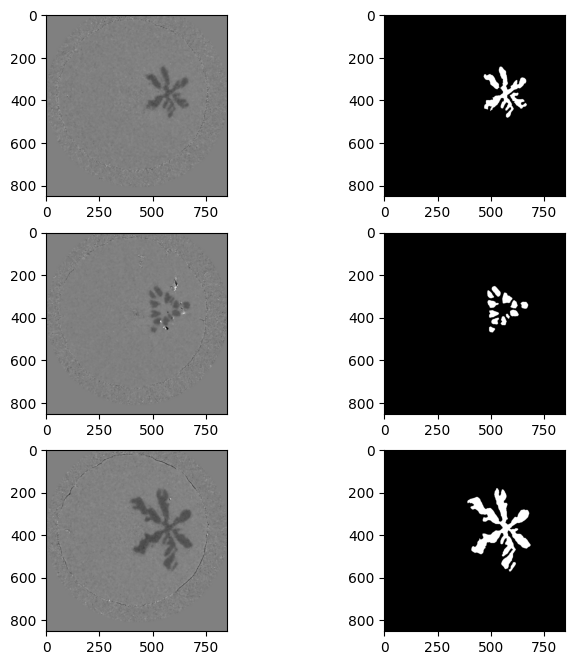

In [7]:
fig, axs = plt.subplots(3,2, figsize=(8,8))
for i in range(3):
    axs[i][0].imshow(X[i])
    axs[i][1].imshow(y[i])

# Building a Model
## Resize to Match UNet
UNet requires images to be of a size multiple of 32, so we'll resize them here.

In [8]:
new_size = 32*10 # U-Net requires a multiple of 32

X_r = np.array([cv2.resize(img, dsize=(new_size, new_size))
     for img in X])
y_r = np.array([cv2.resize(mask, dsize=(new_size, new_size))
     for mask in y])

In [9]:
y_r.shape

(30, 320, 320, 3)

## Create UNet Model

In [10]:
input_shape = (new_size,new_size,3)

model = custom_unet(input_shape)

In [11]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 320, 320, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 320, 320, 16)         432       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 320, 320, 16)         64        ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 spatial_dropout2d (Spatial  (None, 320, 320, 16)         0         ['batch_normalization[0][0

# Preview the Segmentation Task

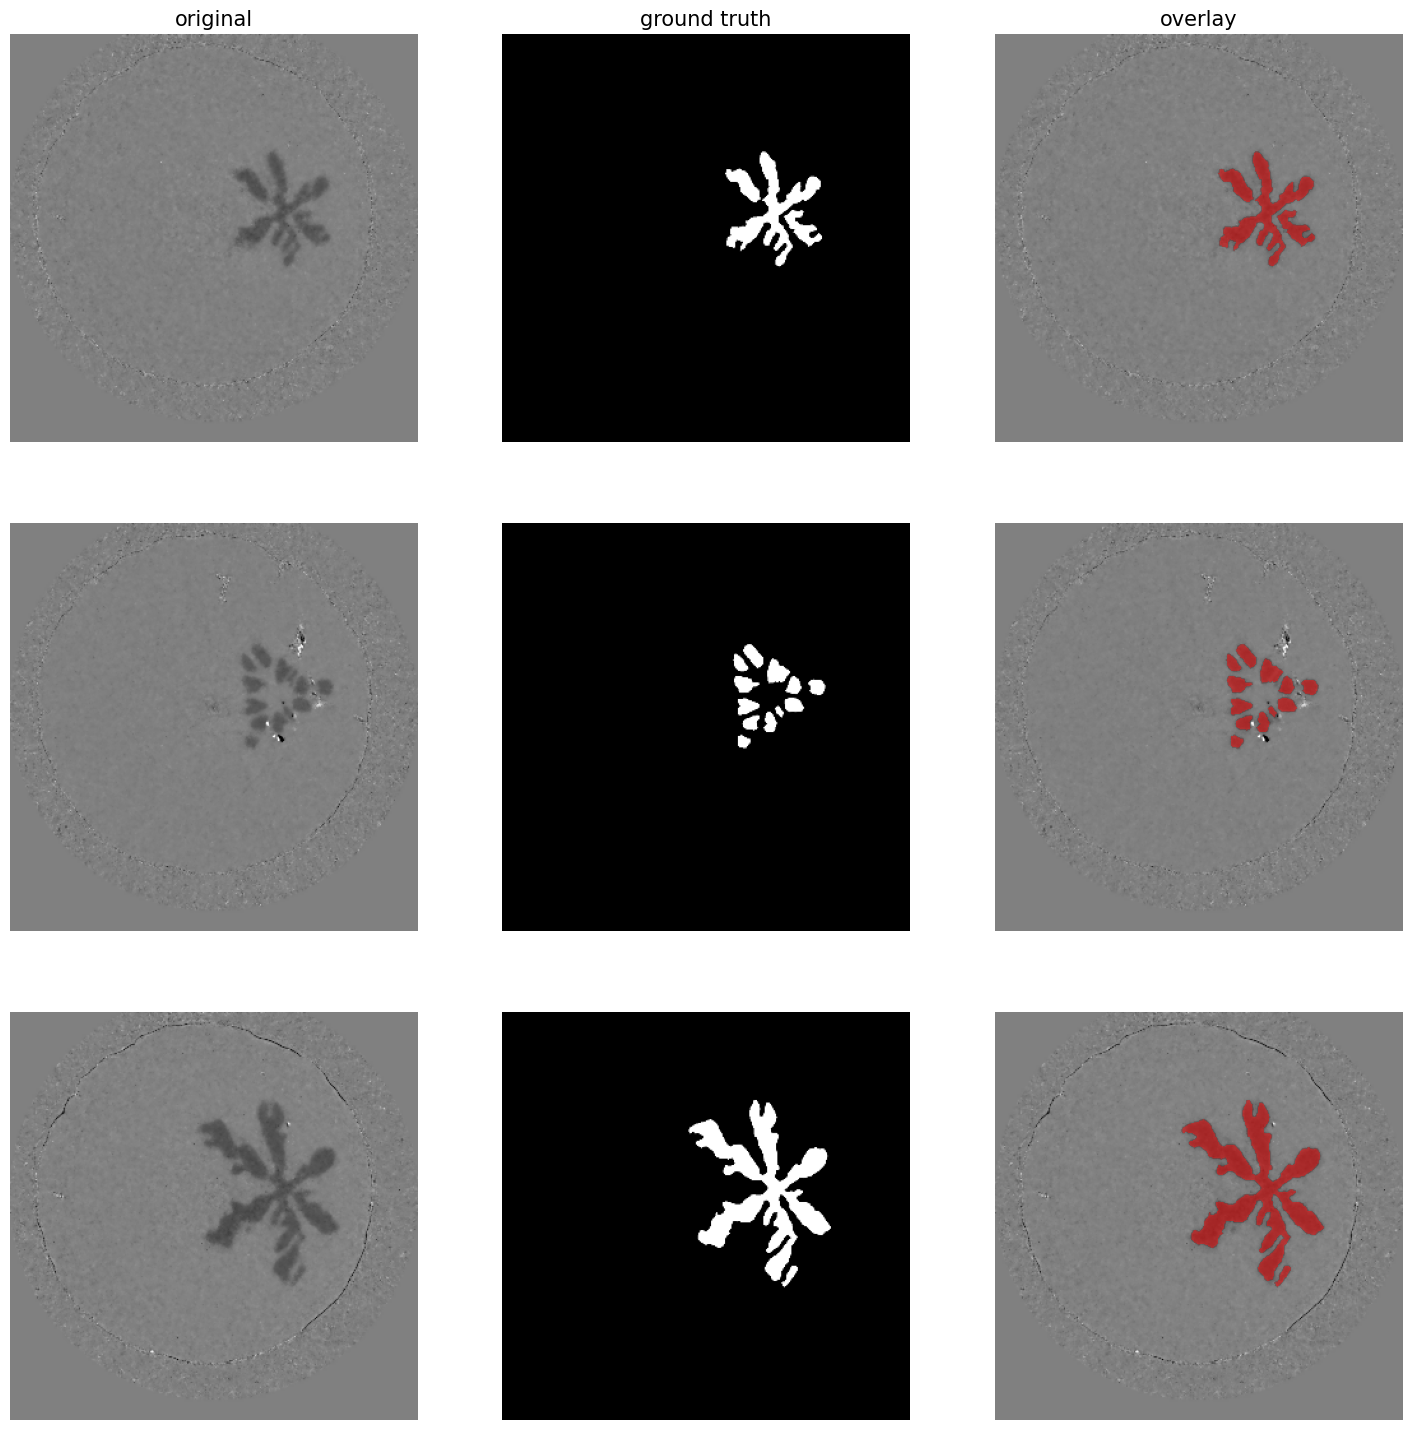

In [12]:
plot_imgs(org_imgs=X_r, mask_imgs=y_r[:,:,:,0], nm_img_to_plot=3, figsize=6)

# Create a Generator with Augmented Images

In [13]:
X_r.shape

(30, 320, 320, 3)

In [14]:
y_r.shape

(30, 320, 320, 3)

In [15]:
n_images = 30
y_c = y_r[:,:,:,0]

train_gen = get_augmented(
    X_r, np.reshape(y_c, (n_images, new_size, new_size, 1)), batch_size=2,
    data_gen_args = dict(
        rotation_range=5.,
        width_shift_range=0.05,
        height_shift_range=0.05,
        shear_range=30,
        zoom_range=0.2,
        horizontal_flip=True,
        vertical_flip=True,
        fill_mode='constant'
    ))

# Preview Augmented Images

(2, 320, 320, 3) (2, 320, 320, 1)


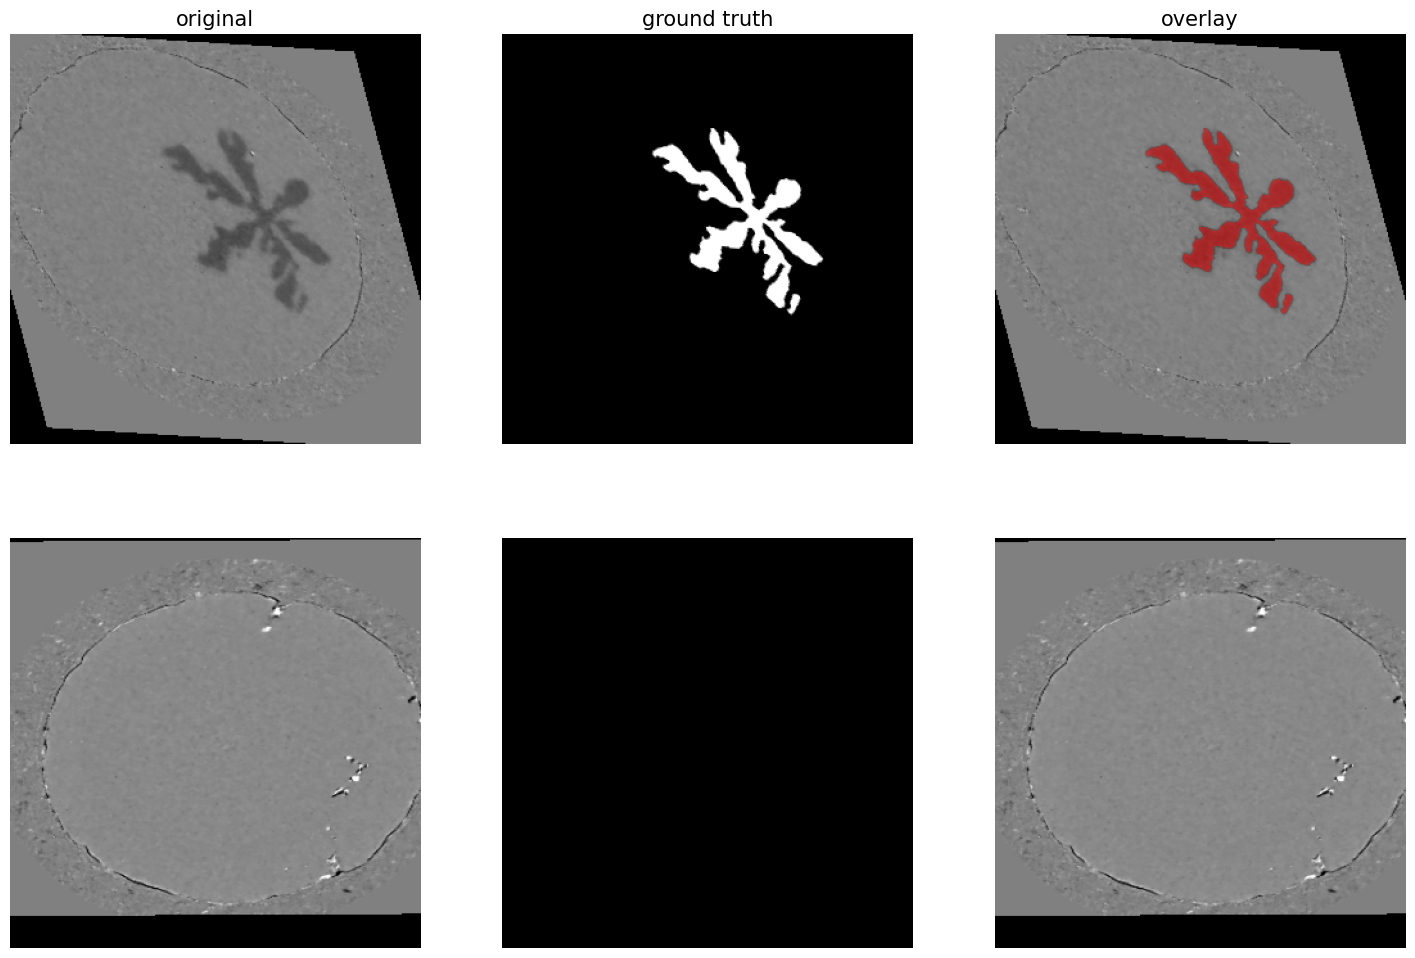

In [16]:
sample_batch = next(train_gen)
xx, yy = sample_batch
print(xx.shape, yy.shape)
from keras_unet.utils import plot_imgs

plot_imgs(org_imgs=xx, mask_imgs=yy[:,:,:,0], nm_img_to_plot=2, figsize=6)

# Compile Model

In [ ]:
model.compile(
    optimizer="adam",
    #optimizer=SGD(lr=0.01, momentum=0.99),
    loss='binary_crossentropy',
    #loss=jaccard_distance,
    metrics=[tf.keras.metrics.MeanIoU(num_classes=2)]
)

# Fit Model

In [ ]:
history = model.fit(
train_gen,
    steps_per_epoch=200,
    epochs=10
)

In [ ]:
model_name = f"./{new_size}x{new_size}-model.h5"
model.save(model_name)

In [ ]:
model = tf.keras.models.load_model(model_name)

# Run Predict on Images

In [ ]:
y_pred = model.predict(X_r)

# Check Performance Visually

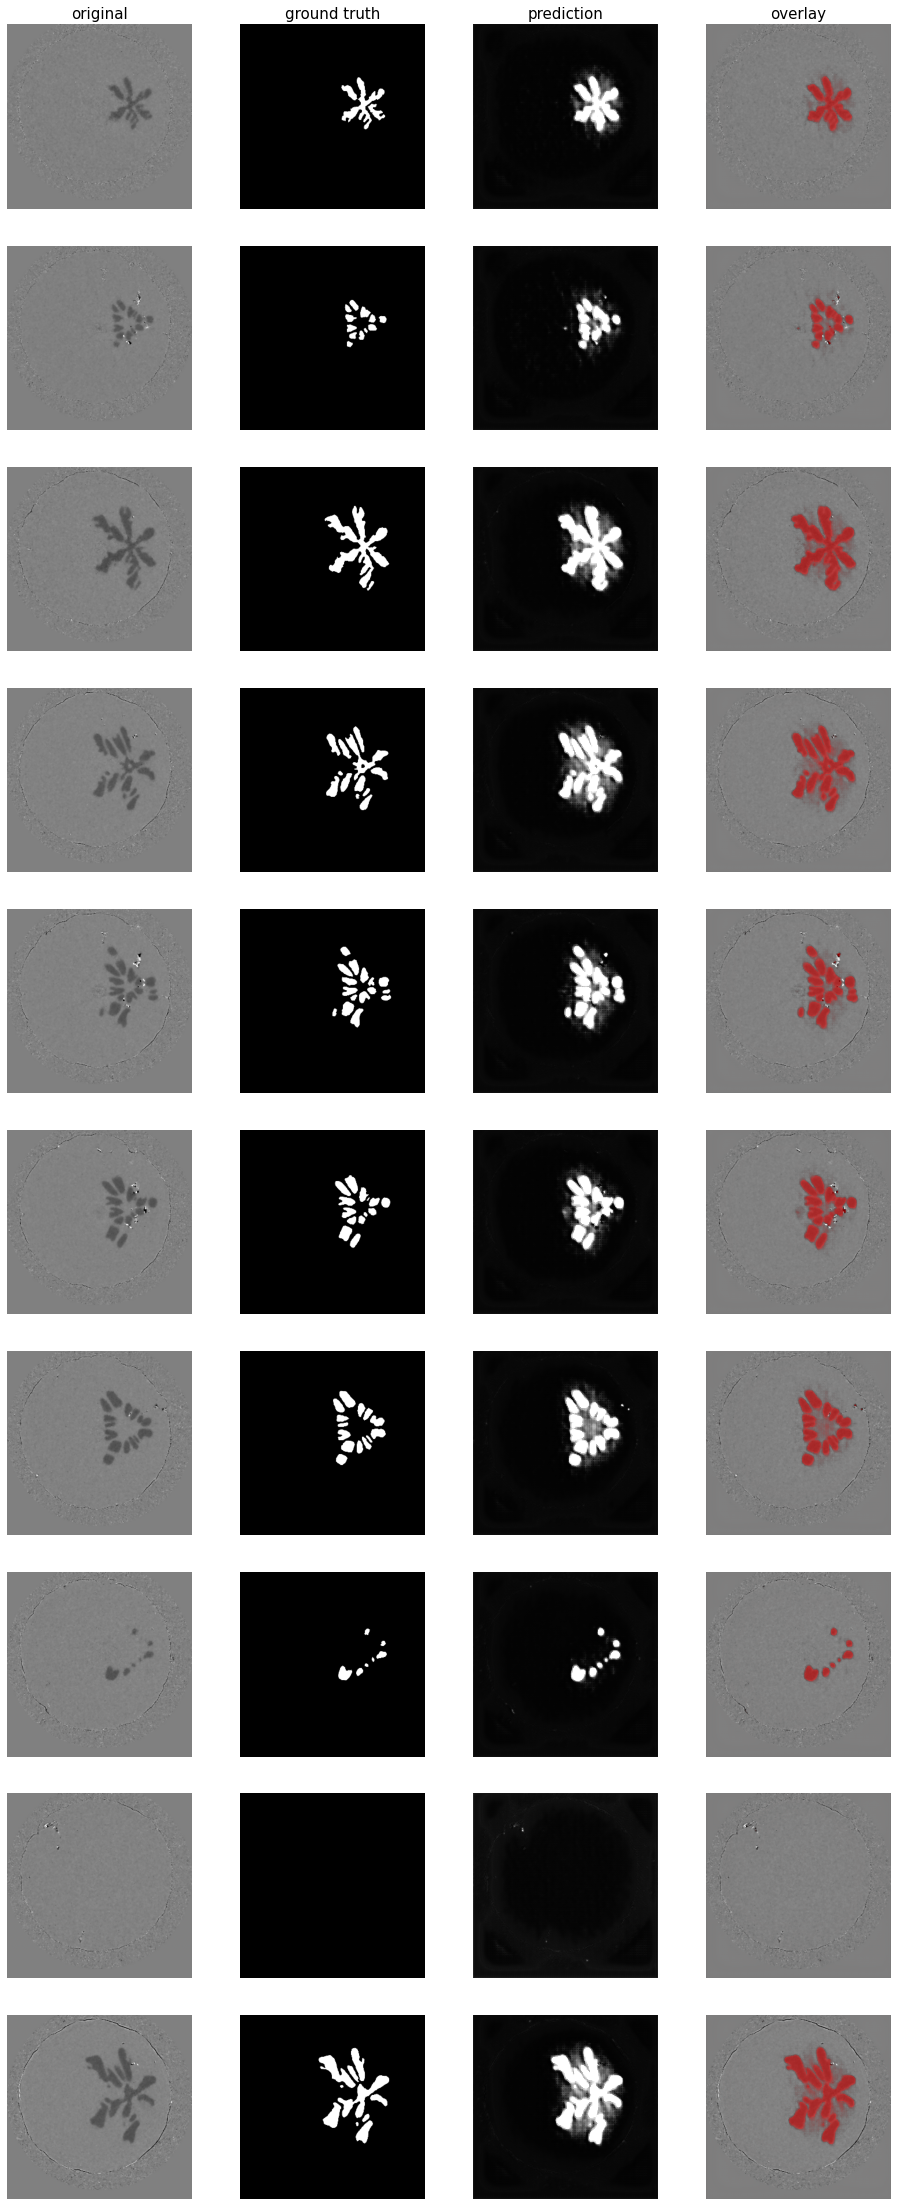

In [ ]:
plot_imgs(org_imgs=X_r, mask_imgs=y_c, pred_imgs=y_pred, nm_img_to_plot=10)